# Hyperparam optimisation

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [44]:
import pandas as pd
import warnings
import seaborn as sns

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
)

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap

from sklearn.metrics import mean_squared_error


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

In [4]:
df_filt = df.loc[lambda x: x.year<=30].reset_index(drop=True)

In [92]:
X = (
    df_filt
    .drop([
        'best_dose',
        'n_pos_diff'
    ], axis=1)
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

y = df_filt.loc[:, ['run', 'best_dose']]

In [93]:
X.head()

,run,year,mu,b,asymp,dec_rate,m_prop,m_scale
0,0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789
1,0,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789
2,0,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789
3,0,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789
4,0,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789


# Fit XGBoost model and find good hyperparams

In [164]:
np.random.seed(0)

# ignore warning about Int64Index
warnings.simplefilter(action='ignore', category=FutureWarning)

Get data (by run)

In [134]:
# reset index? Might help with Int64Index XGB warning
X_cv = X.loc[lambda x: (x.run<800)].drop('run', axis=1)
y_cv = y.loc[lambda x: (x.run<800)].drop('run', axis=1)

X_test = X.loc[lambda x: (x.run>=800)].drop('run', axis=1)
y_test = np.array(y.loc[lambda x: (x.run>=800)].drop('run', axis=1))

How do the default params do?

In [165]:
rmse_list = []
        
kf = KFold(n_splits=10)

for train_ind, val_ind in kf.split(X_cv):

    X_tr = X_cv.iloc[train_ind]
    y_tr = y_cv.iloc[train_ind]

    X_v = X_cv.iloc[val_ind]
    y_v = y_cv.iloc[val_ind]

    y_tr = np.array(y_tr)
    y_v = np.array(y_v)

    model = XGBRegressor().fit(X_tr, y_tr)

    y_p = model.predict(X_v)

    rmse = mean_squared_error(y_p, y_v, squared=False)

    rmse_list.append(rmse)

score = sum(rmse_list)/len(rmse_list)

score

0.15968533709783447

## Hyperparam opt

In [145]:
class HyperparamsObj:
    def __init__(self, X_in, y_in) -> None:
        self.X = X_in
        self.y = y_in
        
    #
    #

    def __call__(self, trial):

        params = self.get_params(trial)

        score = self.run_model(params)

        return score

    #
    #

    def run_model(self, params):
        
        X, y = self.X, self.y
        
        rmse_list = []
        
        kf = KFold(n_splits=5)

        for train_ind, val_ind in kf.split(X):
            
            X_tr = X.iloc[train_ind]
            y_tr = y.iloc[train_ind]
            
            X_v = X.iloc[val_ind]
            y_v = y.iloc[val_ind]
            
            y_tr = np.array(y_tr)
            y_v = np.array(y_v)
        
            model = XGBRegressor(**params).fit(X_tr, y_tr)

            y_p = model.predict(X_v)
            
            rmse = mean_squared_error(y_p, y_v, squared=False)

            rmse_list.append(rmse)
        
        score = sum(rmse_list)/len(rmse_list)

        return score

    #
    #

    def get_params(self, trial):
        params = {
            "tree_method": "hist",
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1),
        }
        return params

In [163]:
optuna.logging.set_verbosity(1)

In [146]:
obj = HyperparamsObj(X_cv, y_cv)

sampler = TPESampler(seed=10)
study = optuna.create_study(sampler=sampler)

[I 2022-07-28 10:09:22,414] A new study created in memory with name: no-name-4039f31e-8de0-47d7-8a8d-b34404356c06


In [156]:
study.optimize(obj, n_trials=20)

[I 2022-07-28 10:28:45,914] Trial 27 finished with value: 0.1801569079841139 and parameters: {'max_depth': 11, 'n_estimators': 103, 'learning_rate': 0.03659800427873522, 'subsample': 0.5334946164004248, 'colsample_bytree': 0.7974646503172621}. Best is trial 12 with value: 0.15576165504511968.
[I 2022-07-28 10:29:12,287] Trial 28 finished with value: 0.18216649820380942 and parameters: {'max_depth': 10, 'n_estimators': 417, 'learning_rate': 0.10243814342858727, 'subsample': 0.7046148981334948, 'colsample_bytree': 0.7350651872857042}. Best is trial 12 with value: 0.15576165504511968.
[I 2022-07-28 10:29:22,493] Trial 29 finished with value: 0.15783733379196002 and parameters: {'max_depth': 7, 'n_estimators': 213, 'learning_rate': 0.17258658669110846, 'subsample': 0.5074579548883937, 'colsample_bytree': 0.9222223805337435}. Best is trial 12 with value: 0.15576165504511968.
[I 2022-07-28 10:29:25,799] Trial 30 finished with value: 0.17375129676768392 and parameters: {'max_depth': 4, 'n_est

## Plots

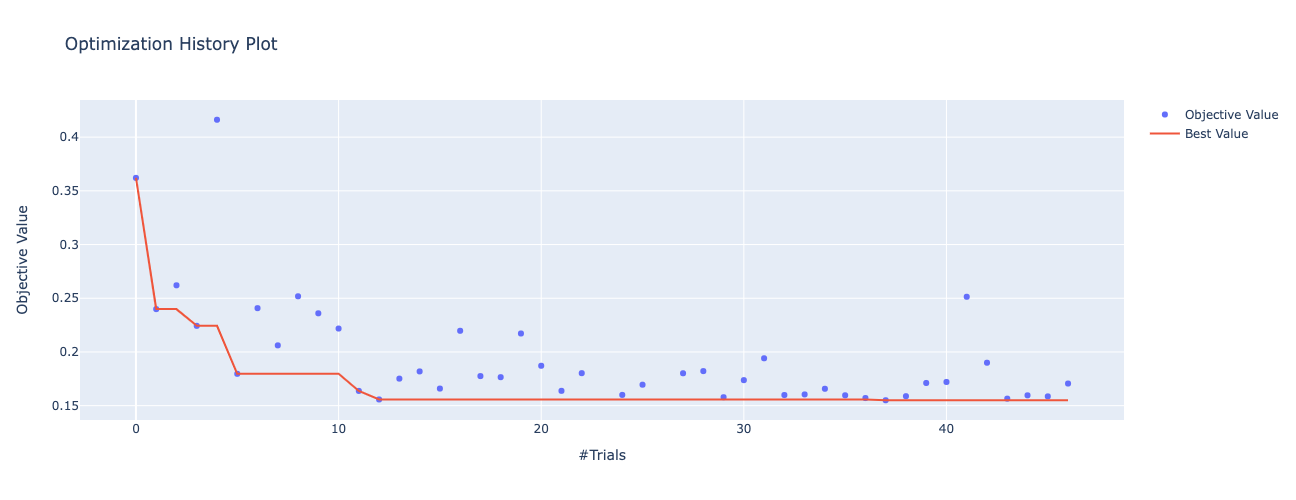

In [157]:
f = plot_optimization_history(study)
f.update_layout(height=500)

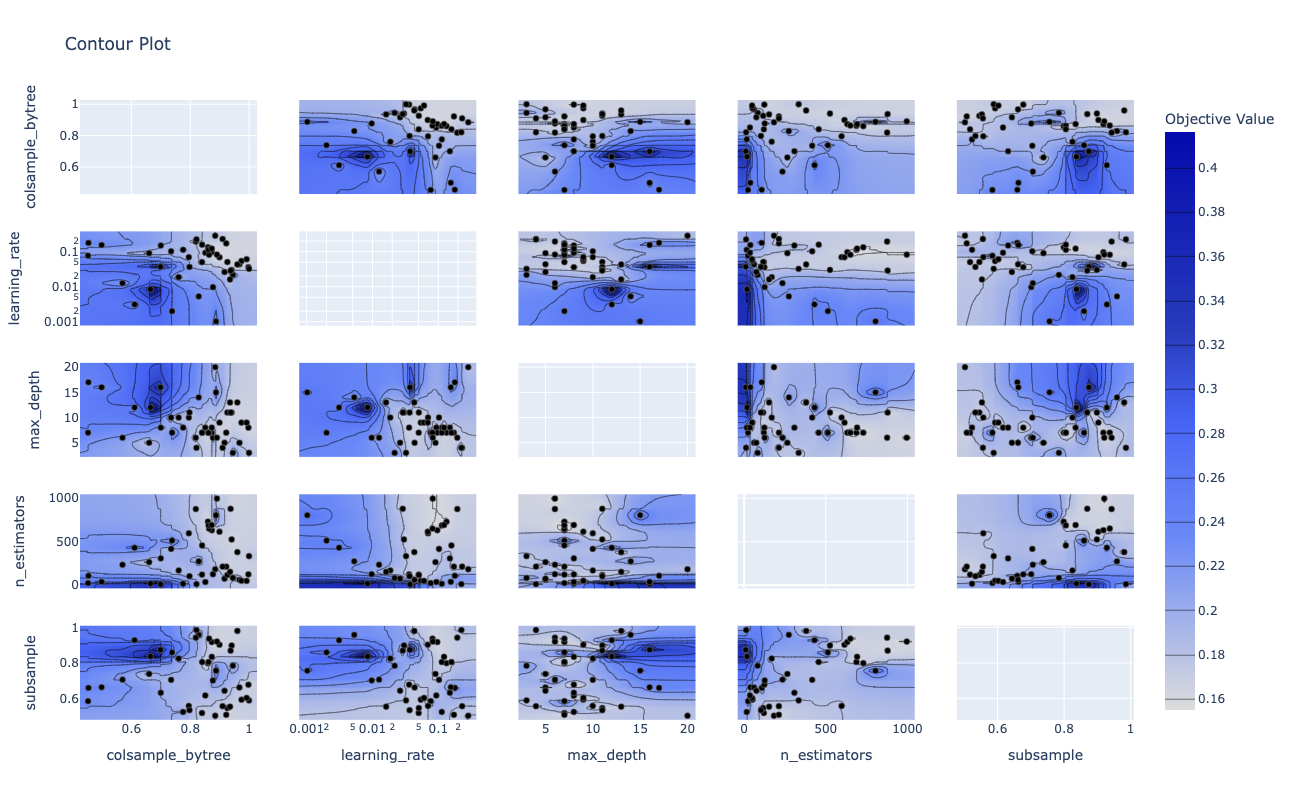

In [158]:
f = plot_contour(study)
f.update_layout(height=800)

## Check performance of best model

In [162]:
best_pars = study.best_params

best_pars

{'max_depth': 7,
 'n_estimators': 651,
 'learning_rate': 0.08156685542862815,
 'subsample': 0.9373208009457853,
 'colsample_bytree': 0.8640335904228108}

In [160]:
best_model = XGBRegressor(**best_pars).fit(X_cv, y_cv)

y_p = best_model.predict(X_test)

rmse = mean_squared_error(y_p, y_test, squared=False)

rmse

0.13335850619937392

In [161]:
# model = XGBRegressor().fit(X_train_val, y_train_val)
model = XGBRegressor().fit(X_cv, y_cv)

y_p = model.predict(X_test)

rmse = mean_squared_error(y_p, y_test, squared=False)

rmse

0.13741370447251908

### Save model

In [166]:
best_model.save_model('xgb_scan_all.json')